In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/MyDrive/Dataset/Paired/underwater_dark"
trainA_path = dataset_path + "/trainA"  # Poor images
trainB_path = dataset_path + "/trainB"  # Good images

In [ ]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to load and preprocess images
def load_images(image_path, size=(256, 256)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, size)
    image = tf.cast(image, tf.float32) / 127.5 - 1  # Normalize to [-1, 1]
    return image

# Load paired dataset
def load_paired_dataset(trainA_path, trainB_path):
    trainA_images = sorted([os.path.join(trainA_path, fname) for fname in os.listdir(trainA_path)])
    trainB_images = sorted([os.path.join(trainB_path, fname) for fname in os.listdir(trainB_path)])

    dataset = tf.data.Dataset.from_tensor_slices((trainA_images, trainB_images))
    dataset = dataset.map(lambda x, y: (load_images(x), load_images(y)))
    dataset = dataset.batch(1)  # Batch size of 1 for GAN training
    return dataset

# Load the dataset
paired_dataset = load_paired_dataset(trainA_path, trainB_path)

In [ ]:
def build_generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Downsampling
    down1 = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    down1 = tf.keras.layers.LeakyReLU()(down1)

    down2 = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same')(down1)
    down2 = tf.keras.layers.BatchNormalization()(down2)
    down2 = tf.keras.layers.LeakyReLU()(down2)

    down3 = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same')(down2)
    down3 = tf.keras.layers.BatchNormalization()(down3)
    down3 = tf.keras.layers.LeakyReLU()(down3)

    # Bottleneck
    bottleneck = tf.keras.layers.Conv2D(512, 4, strides=2, padding='same')(down3)
    bottleneck = tf.keras.layers.BatchNormalization()(bottleneck)
    bottleneck = tf.keras.layers.LeakyReLU()(bottleneck)

    # Upsampling
    up1 = tf.keras.layers.Conv2DTranspose(256, 4, strides=2, padding='same')(bottleneck)
    up1 = tf.keras.layers.BatchNormalization()(up1)
    up1 = tf.keras.layers.ReLU()(up1)

    up2 = tf.keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same')(up1)
    up2 = tf.keras.layers.BatchNormalization()(up2)
    up2 = tf.keras.layers.ReLU()(up2)

    up3 = tf.keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same')(up2)
    up3 = tf.keras.layers.BatchNormalization()(up3)
    up3 = tf.keras.layers.ReLU()(up3)

    # Output layer
    outputs = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(up3)

    return tf.keras.Model(inputs, outputs)

In [ ]:
def build_discriminator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv2D(512, 4, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    outputs = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same')(x)

    return tf.keras.Model(inputs, outputs)

In [ ]:
# Adversarial loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output, generated_images, target_images):
    adv_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    l1_loss = tf.reduce_mean(tf.abs(target_images - generated_images))
    return adv_loss + 100 * l1_loss  # Weighted L1 loss

In [ ]:
generator = build_generator()
discriminator = build_discriminator()

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Training loop
@tf.function
def train_step(input_images, target_images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(input_images, training=True)

        real_output = discriminator(target_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output, generated_images, target_images)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Train the model
EPOCHS = 50
for epoch in range(EPOCHS):
    for input_image, target_image in paired_dataset:
        train_step(input_image, target_image)
    print(f"Epoch {epoch + 1}/{EPOCHS} completed")

Epoch 1/50 completed
Epoch 2/50 completed
Epoch 3/50 completed
Epoch 4/50 completed
Epoch 5/50 completed
Epoch 6/50 completed
Epoch 7/50 completed
Epoch 8/50 completed
Epoch 9/50 completed
Epoch 10/50 completed
Epoch 11/50 completed
Epoch 12/50 completed
Epoch 13/50 completed
Epoch 14/50 completed
Epoch 15/50 completed
Epoch 16/50 completed
Epoch 17/50 completed
Epoch 18/50 completed
Epoch 19/50 completed
Epoch 20/50 completed
Epoch 21/50 completed
Epoch 22/50 completed
Epoch 23/50 completed
Epoch 24/50 completed
Epoch 25/50 completed
Epoch 26/50 completed
Epoch 27/50 completed
Epoch 28/50 completed
Epoch 29/50 completed
Epoch 30/50 completed
Epoch 31/50 completed
Epoch 32/50 completed
Epoch 33/50 completed
Epoch 34/50 completed
Epoch 35/50 completed
Epoch 36/50 completed
Epoch 37/50 completed
Epoch 38/50 completed
Epoch 39/50 completed
Epoch 40/50 completed
Epoch 41/50 completed
Epoch 42/50 completed
Epoch 43/50 completed
Epoch 44/50 completed
Epoch 45/50 completed
Epoch 46/50 complet

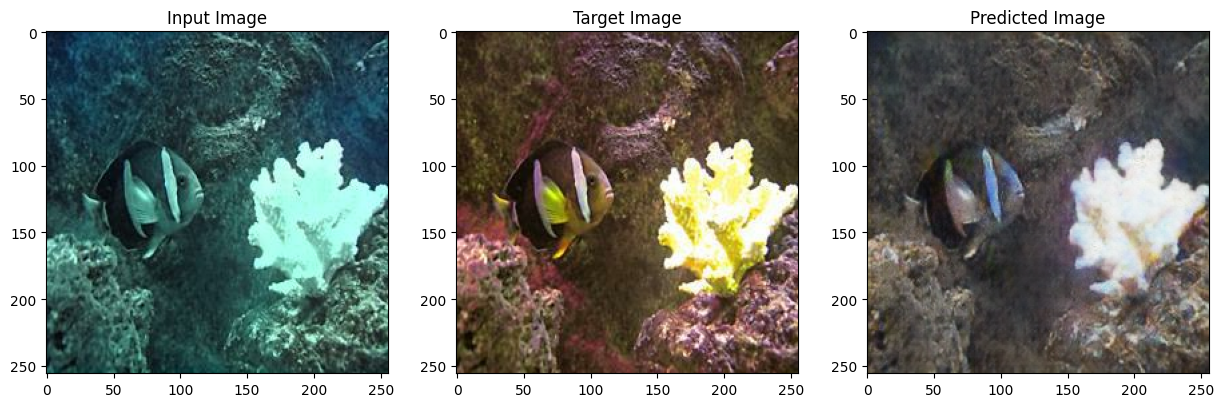

In [ ]:
generator.save('/content/drive/MyDrive/FUiNE-GAN/funie_gan_generator.h5')

# Test the model
def predict(image_path):
    image = load_images(image_path)
    prediction = generator(image[np.newaxis, ...], training=False)
    return prediction[0]

# Visualize results
def plot_results(input_image, target_image, predicted_image):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow((input_image + 1) / 2)  # Denormalize

    plt.subplot(1, 3, 2)
    plt.title("Target Image")
    plt.imshow((target_image + 1) / 2)

    plt.subplot(1, 3, 3)
    plt.title("Predicted Image")
    plt.imshow((predicted_image + 1) / 2)
    plt.show()

# Test on a sample image
sample_image_path = "/content/drive/MyDrive/Dataset/Paired/underwater_dark/trainA/264286_00007889.jpg"
input_image = load_images(sample_image_path)
target_image = load_images(sample_image_path.replace("trainA", "trainB"))
predicted_image = predict(sample_image_path)

plot_results(input_image, target_image, predicted_image)